# Parameter estimation for 1D heat equation by MH-McMC


Iteration 1000/10000 completed
Iteration 2000/10000 completed
Iteration 3000/10000 completed
Iteration 4000/10000 completed
Iteration 5000/10000 completed
Iteration 6000/10000 completed
Iteration 7000/10000 completed
Iteration 8000/10000 completed
Iteration 9000/10000 completed
Iteration 10000/10000 completed


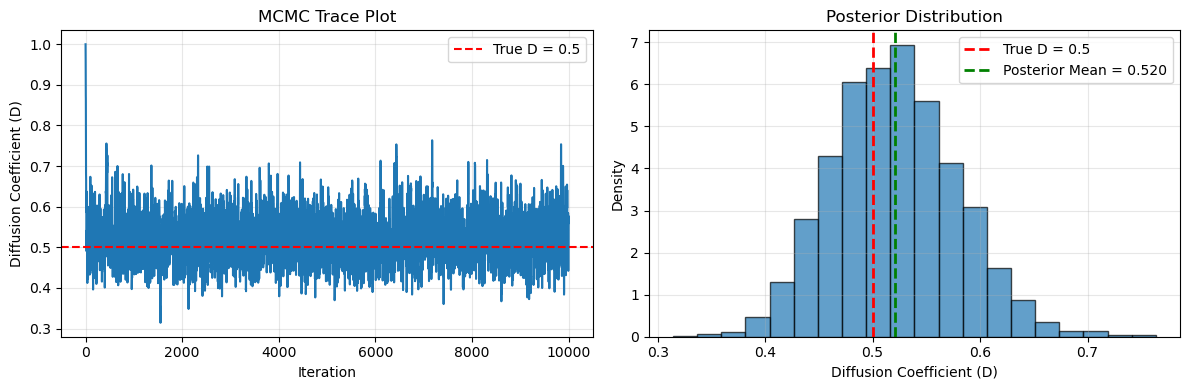


MCMC SUMMARY
True diffusion coefficient: 0.5
Estimated diffusion coefficient: 0.5204
Posterior mean: 0.5204
Posterior median: 0.5186
Posterior std: 0.0583
95% Credible Interval: [0.4150, 0.6397]
Acceptance rate: 68.31%


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#--- OneDHeatIP.py ---#
# Solve parameter estimation inverse problem 
# for the 1D heat equation

# Problem parameters
L = 10
D = 0.5
s = 0.03
Tmax = 2
xdim = 25
tdim = 75

# Discretization
x = np.linspace(0, L, xdim)
t = np.linspace(0, Tmax, tdim)
dx = x[1] - x[0]
dt = t[1] - t[0]
q = dt / dx**2
r1 = 0.75 * L
r2 = 0.8 * L

# Initial condition
u0 = np.zeros(xdim)
u0[(x >= r1) & (x <= r2)] = 1

xDat = np.arange(1, xdim-1)  
tDat = np.array([tdim-1])    
nxDat = len(xDat)
ntDat = len(tDat)

# Heat equation solver function
def heat(D, u0, q, tdim):
    """
    Solve 1D heat equation using finite differences
    
    Parameters:
    -----------
    D : float
        Diffusion coefficient
    u0 : array
        Initial condition
    q : float
        dt/dx^2 ratio
    tdim : int
        Number of time steps
    
    Returns:
    --------
    Z : array
        Solution matrix (tdim x xdim)
    """
    xdim = len(u0)
    Z = np.zeros((tdim, xdim))
    Z[0, :] = u0
    
    for tin in range(1, tdim):
        tip = tin - 1
        Z[tin, 1:-1] = Z[tip, 1:-1] + \
            D * q * (Z[tip, 0:-2] - 2*Z[tip, 1:-1] + Z[tip, 2:])
    
    return Z

# Set random seed for reproducibility (optional)
np.random.seed(12)

# Solve the heat equation with true parameter
Z = heat(D, u0, q, tdim)
u = Z[np.ix_(tDat, xDat)]  # solution at time T
uDat = u + s * np.random.randn(ntDat, nxDat) # noisy observations at time T

# Metropolis-Hastings MCMC
N = 10000
XD = 1
X = np.zeros(N)
X[0] = XD

Z = heat(XD, u0, q, tdim)
u = Z[np.ix_(tDat, xDat)]
oLLkd = np.sum(-(u - uDat)**2) / (2 * s**2)
LL = np.zeros(N)
LL[0] = oLLkd

w = 0.1

# Main MCMC loop
for n in range(1, N):
    XDp = XD + w * (2*np.random.rand() - 1)
    
    if XDp > 0:
        Z = heat(XDp, u0, q, tdim)
        u = Z[np.ix_(tDat, xDat)]
        nLLkd = np.sum(-(u - uDat)**2) / (2 * s**2)
        alpha = np.exp(nLLkd - oLLkd)
        
        if np.random.rand() < alpha:
            XD = XDp
            oLLkd = nLLkd
    
    X[n] = XD
    LL[n] = oLLkd
    
    # Progress indicator
    if (n+1) % 1000 == 0:
        print(f"Iteration {n+1}/{N} completed")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot trace
axes[0].plot(X)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Diffusion Coefficient (D)')
axes[0].set_title('MCMC Trace Plot')
axes[0].axhline(y=D, color='r', linestyle='--', label=f'True D = {D}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot histogram
burn_in = 1000
axes[1].hist(X[burn_in:], bins=20, density=True, alpha=0.7, edgecolor='black')
axes[1].axvline(x=D, color='r', linestyle='--', linewidth=2, label=f'True D = {D}')
axes[1].axvline(x=np.mean(X[burn_in:]), color='g', linestyle='--', linewidth=2, 
                label=f'Posterior Mean = {np.mean(X[burn_in:]):.3f}')
axes[1].set_xlabel('Diffusion Coefficient (D)')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
D_estimated = np.mean(X[burn_in:])
print("\n" + "="*50)
print("MCMC SUMMARY")
print("="*50)
print(f"True diffusion coefficient: {D}")
print(f"Estimated diffusion coefficient: {D_estimated:.4f}")
print(f"Posterior mean: {np.mean(X[burn_in:]):.4f}")
print(f"Posterior median: {np.median(X[burn_in:]):.4f}")
print(f"Posterior std: {np.std(X[burn_in:]):.4f}")
print(f"95% Credible Interval: [{np.percentile(X[burn_in:], 2.5):.4f}, {np.percentile(X[burn_in:], 97.5):.4f}]")
print(f"Acceptance rate: {np.mean(np.diff(X[burn_in:]) != 0):.2%}")

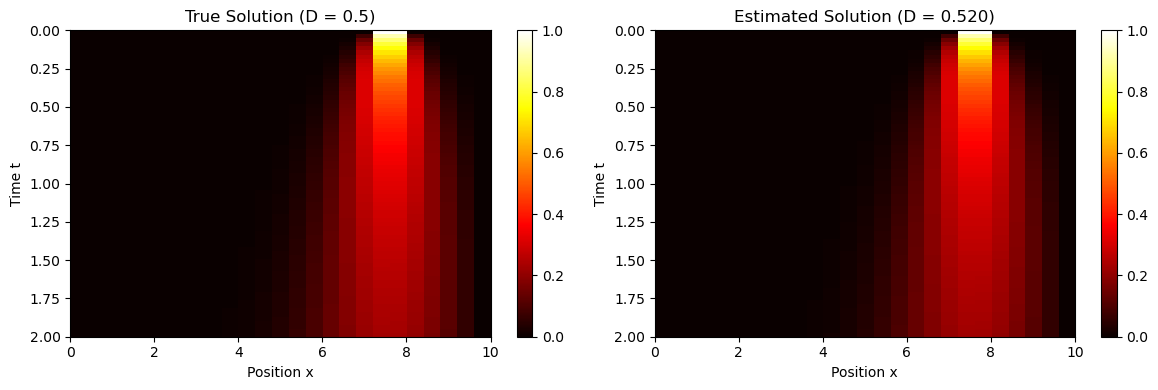

In [2]:
# Optional: Plot the solution with estimated parameter
burn_in = 1000
D_estimated = np.mean(X[burn_in:])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# True solution
Z_true = heat(D, u0, q, tdim)
axes[0].imshow(Z_true, aspect='auto', extent=[0, L, Tmax, 0], cmap='hot')
axes[0].set_xlabel('Position x')
axes[0].set_ylabel('Time t')
axes[0].set_title(f'True Solution (D = {D})')
plt.colorbar(axes[0].images[0], ax=axes[0])

# Estimated solution
Z_est = heat(D_estimated, u0, q, tdim)
axes[1].imshow(Z_est, aspect='auto', extent=[0, L, Tmax, 0], cmap='hot')
axes[1].set_xlabel('Position x')
axes[1].set_ylabel('Time t')
axes[1].set_title(f'Estimated Solution (D = {D_estimated:.3f})')
plt.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

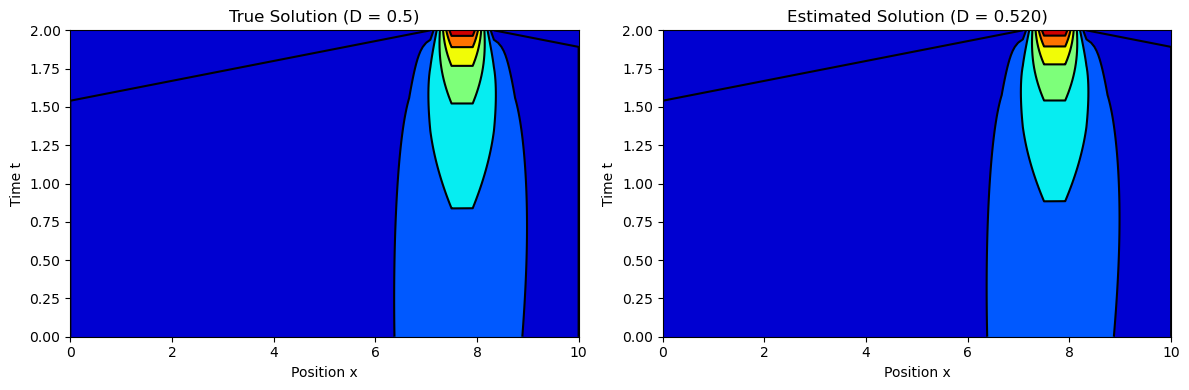

In [3]:
# Optional: Plot the solution with estimated parameter
burn_in = 1000
D_estimated = np.mean(X[burn_in:])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# True solution
Z_true = heat(D, u0, q, tdim)
axes[0].contourf(Z_true, extent=[0, L, Tmax, 0], cmap='jet')
axes[0].contour(Z_true,  extent=[0, L, Tmax, 0], colors='k')
axes[0].set_xlabel('Position x')
axes[0].set_ylabel('Time t')
axes[0].set_title(f'True Solution (D = {D})')
#plt.colorbar(axes[0].images[0], ax=axes[0])

# Estimated solution
Z_est = heat(D_estimated, u0, q, tdim)
axes[1].contourf(Z_est,  extent=[0, L, Tmax, 0], cmap='jet')
axes[1].contour(Z_est,  extent=[0, L, Tmax, 0], colors='k')
axes[1].set_xlabel('Position x')
axes[1].set_ylabel('Time t')
axes[1].set_title(f'Estimated Solution (D = {D_estimated:.3f})')
#plt.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()